In [1]:
## ANALISIS DE RIESGOS GEOPOLÍTICOS MEDIANTE MODELOS XGBOOST ##

## Load librarys
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    r2_score, mean_absolute_error,
    mean_squared_error, mean_absolute_percentage_error
)
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid


In [3]:
## load data
## open drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/df_reduced_var_processed.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## DATA CLASSIFICATION

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   week                      783 non-null    object 
 1   GPRC_BEL                  783 non-null    float64
 2   GPRC_CAN                  783 non-null    float64
 3   GPRC_CHN                  783 non-null    float64
 4   GPRC_DEU                  783 non-null    float64
 5   GPRC_FRA                  783 non-null    float64
 6   GPRC_GBR                  783 non-null    float64
 7   GPRC_JPN                  783 non-null    float64
 8   GPRC_KOR                  783 non-null    float64
 9   GPRC_POL                  783 non-null    float64
 10  GPRC_SAU                  783 non-null    float64
 11  GPRC_TUR                  783 non-null    float64
 12  GPRC_USA                  783 non-null    float64
 13  conflict_count            417 non-null    float64
 14  OPEP_invol

In [22]:
## clasify data by origin


# week transformation
df["week"] = pd.to_datetime(df["week"])
df["year"] = df["week"].dt.year
df["month"] = df["week"].dt.month
df = df.drop(columns=["week"])


# mask columns not necesary in xgboost models
columnas_a_eliminar = ['OPEP_conflict_count','conflict_count','Iran_conflict_count','USA_involved','shock_event','Iran_involved','OPEP_involved']
df = df.drop(columns=columnas_a_eliminar)

# define features and target
target = ['close_oil_norm','close_gas_norm','close_gold_norm']
features = df.columns.drop(target)

# Clasificación por nombre o explícita
gpr_cols = [col for col in df.columns if col.startswith("GPRC_")]
gepu_cols = [col for col in df.columns if col.startswith("GEPU_")] + ["GEPU_current"]
zew_cols = [col for col in df.columns if "zew" in col.lower()]

conflict_cols = [
    "conflict_count_mask",
    "OPEP_involved_mask",
    "OPEP_conflict_count_mask",
    "USA_involved_mask",
    "Iran_involved_mask",
    "Iran_conflict_count_mask",
    "shock_event_mask"
]

election_cols = [
    "num_elections",
    "elections_next_6_weeks",
    "num_compulsory_voting",
    "avg_voter_turnout"
]

sanction_cols = [
    "OPEP_sanction_active",
    "num_sanctions"
]

gold_cols = [
    "Volume_gold",
    "kurtosis_gold"
]

oil_cols = [
    "Volume_oil",
    "kurtosis_oil"
]

gas_cols = [
    "Volume_gas",
    "kurtosis_gas"
]

time_cols = [
    "year",
    "month"
]

# Todas las columnas clasificadas (sin incluir targets)
todas_las_cols = (
    gpr_cols + gepu_cols + zew_cols + conflict_cols + election_cols +
    sanction_cols + gold_cols + oil_cols + gas_cols + time_cols
)

# Variables no clasificadas
otras_cols = list(set(df.columns) - set(todas_las_cols + target))

# Diccionario final de fuentes
fuentes = {
    "GPR": gpr_cols,
    "GEPU": gepu_cols,
    "ZEW": zew_cols,
    "Conflicts": conflict_cols,
    "Elections": election_cols,
    "Sanctions": sanction_cols,
    "Gold": gold_cols,
    "Oil": oil_cols,
    "Gas": gas_cols,
    "Time": time_cols,
    "Otros": otras_cols }

df = df.astype('float64')


In [ ]:
# check the variables clasiffication
variables_clasificadas = []

for clase, columnas in fuentes.items():
    for col in columnas:
        variables_clasificadas.append((col, clase))

df_variables = pd.DataFrame(variables_clasificadas, columns=["Variable", "Clase"])

df_variables = df_variables.sort_values(by=["Clase", "Variable"]).reset_index(drop=True)

print(df_variables)


In [31]:
## MODEL FOR OIL BY CATEGORY ##

target = 'close_oil_norm'
metrics_df = pd.DataFrame(columns=['Modelo', 'MAE', 'RMSE', 'R2', 'MAPE'])

# Función de MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función principal
def entrenar_y_evaluar(fuentes_seleccionadas, modelo_nombre):
    selected_features = sum([fuentes[f] for f in fuentes_seleccionadas], [])

    # VERIFICACIÓN: Todos los elementos deben ser strings (nombres de columnas)
    for feature in selected_features:
      if not isinstance(feature, str):
        print(f"Error: '{feature}' es tipo {type(feature)} y no un string")


    X = df[selected_features]
    y = df[target]
    #print(type(y))
    #print(type(X))


    # Split temporal
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


    # Normalizar y solo con train
    mean_y_train = y_train.mean()
    std_y_train = y_train.std()

    y_train_norm = (y_train - mean_y_train) / std_y_train
    y_test_norm = (y_test - mean_y_train) / std_y_train

    # Definir el modelo base
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )

    # Grid de hiperparámetros
    param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 1.0],
    'gamma': [1, 5],
      }


    # GridSearchCV
    grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    #print("X_train type:", type(X_train))
    #print("y_train type:", type(y_train))
    #print("X_train dtypes:\n", X_train.dtypes)
    #print("y_train dtype:", y_train.dtype)
    #print("¿y_train tiene más de una dimensión?:", y_train.ndim)

    #print("Columnas duplicadas:", X_train.columns.duplicated().sum())
    X_train = X_train.loc[:, ~X_train.columns.duplicated()]
    X_test = X_test.loc[:, ~X_test.columns.duplicated()]



    # Entrenamiento
    grid.fit(X_train, y_train)

    # Predicción y evaluación
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)


    ## Deshacer la normalización
    y_pred_real = y_pred * std_y_train + mean_y_train
    y_test_real = y_test_norm * std_y_train + mean_y_train

    # Asegurarse que sean arrays o Series, no DataFrames
    y_test_real = pd.Series(y_test_real)
    y_pred_real = pd.Series(y_pred_real)

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2 = r2_score(y_test_real, y_pred_real)
    mape_val = mape(y_test_real, y_pred_real)
    # Retorno de resultados
    return {
        'Modelo': modelo_nombre,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape_val
    }

# Lista de modelos a probar
modelos_a_probar = [
 (["GPR", "GEPU", "ZEW", "Conflicts", "Elections", "Sanctions", "Oil","Time"], "Modelo_Global"),
 (["GEPU", "ZEW", "Conflicts", "Elections", "Sanctions","Oil", "Time"], "Modelo_sin_GPR"),
 (["GPR", "ZEW", "Conflicts", "Elections", "Sanctions", "Oil","Time"], "Modelo_sin_GEPU"),
 (["GPR", "GEPU", "Conflicts", "Elections", "Sanctions","Oil", "Time"], "Modelo_sin_ZEW"),
 (["GPR", "GEPU", "ZEW", "Elections", "Sanctions","Oil", "Time"], "Modelo_sin_Conflicts"),
 (["GPR", "GEPU", "ZEW", "Conflicts", "Sanctions","Oil", "Time"], "Modelo_sin_Elections"),
 (["GPR", "GEPU", "ZEW", "Conflicts", "Elections","Oil", "Time"], "Modelo_sin_Sanctions"),
]


# Ejecutar todos los modelos y guardar métricas
for fuentes_sel, nombre in modelos_a_probar:
    resultado = entrenar_y_evaluar(fuentes_sel, nombre)
    metrics_df = pd.concat([metrics_df, pd.DataFrame([resultado])], ignore_index=True)

# Mostrar tabla final de métricas
print(metrics_df)

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>
X_train dtypes:
 GPRC_BEL                    float64
GPRC_CAN                    float64
GPRC_CHN                    float64
GPRC_DEU                    float64
GPRC_FRA                    float64
GPRC_GBR                    float64
GPRC_JPN                    float64
GPRC_KOR                    float64
GPRC_POL                    float64
GPRC_SAU                    float64
GPRC_TUR                    float64
GPRC_USA                    float64
GEPU_current                float64
GEPU_Australia              float64
GEPU_Brazil                 float64
GEPU_Canada                 float64
GEPU_Chile                  float64
GEPU_France                 float64
GEPU_Germany                float64
GEPU_Greece                 float64
GEPU_India                  float64
GEPU_Italy                  float64
GEPU_Japan     

/tmp/ipython-input-31-1490972401.py:120: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([resultado])], ignore_index=True)


<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>
X_train dtypes:
 GEPU_current                float64
GEPU_Australia              float64
GEPU_Brazil                 float64
GEPU_Canada                 float64
GEPU_Chile                  float64
GEPU_France                 float64
GEPU_Germany                float64
GEPU_Greece                 float64
GEPU_India                  float64
GEPU_Italy                  float64
GEPU_Japan                  float64
GEPU_Korea                  float64
GEPU_Pakistan               float64
GEPU_Russia                 float64
GEPU_Spain                  float64
GEPU_UK                     float64
GEPU_US                     float64
GEPU_Mexico                 float64
GEPU_current                float64
zew_weekly                  float64
conflict_count_mask         float64
OPEP_involved_mask          float64
OPEP_conflict_c

## BUCLE CON TODOS LOS MODELOS

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   week                      783 non-null    object 
 1   GPRC_BEL                  783 non-null    float64
 2   GPRC_CAN                  783 non-null    float64
 3   GPRC_CHN                  783 non-null    float64
 4   GPRC_DEU                  783 non-null    float64
 5   GPRC_FRA                  783 non-null    float64
 6   GPRC_GBR                  783 non-null    float64
 7   GPRC_JPN                  783 non-null    float64
 8   GPRC_KOR                  783 non-null    float64
 9   GPRC_POL                  783 non-null    float64
 10  GPRC_SAU                  783 non-null    float64
 11  GPRC_TUR                  783 non-null    float64
 12  GPRC_USA                  783 non-null    float64
 13  conflict_count            417 non-null    float64
 14  OPEP_invol

Entrenando Modelo_Global con fuentes: ['GPR', 'GEPU', 'ZEW', 'Conflicts', 'Elections', 'Sanctions', 'Oil', 'Time']


/tmp/ipython-input-4-2861339396.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_roll_4"] = df[col].shift(1).rolling(window=4).mean()
/tmp/ipython-input-4-2861339396.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_1"] = df[col].shift(1)
/tmp/ipython-input-4-2861339396.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

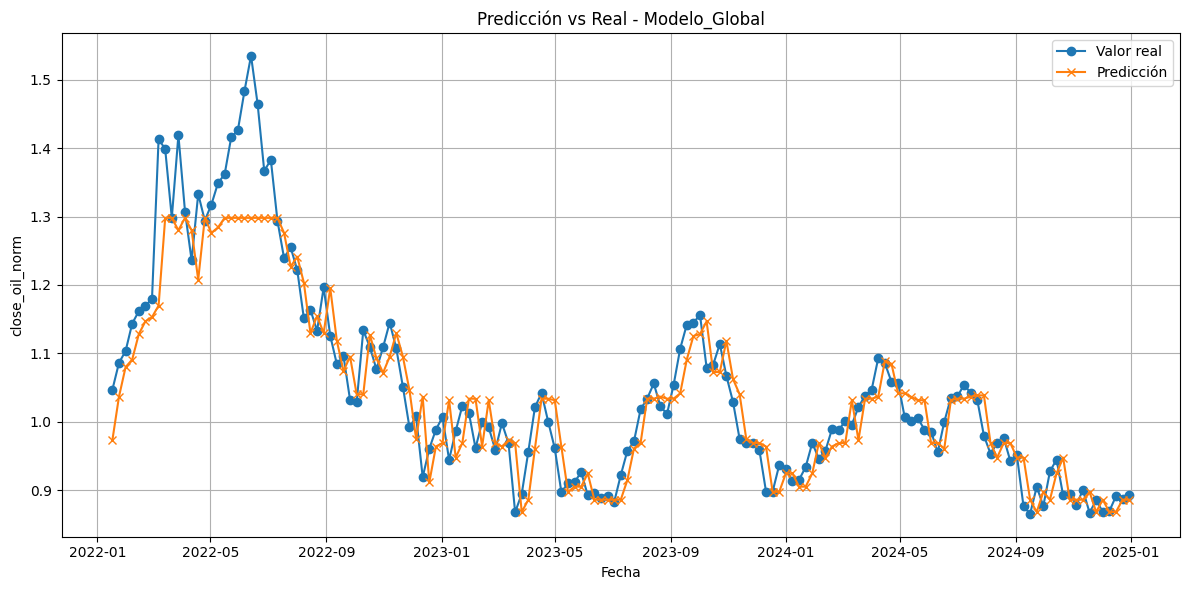

/tmp/ipython-input-4-2861339396.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([resultado_metr])], ignore_index=True)


Entrenando Modelo_sin_GPR con fuentes: ['GEPU', 'ZEW', 'Conflicts', 'Elections', 'Sanctions', 'Oil', 'Time']


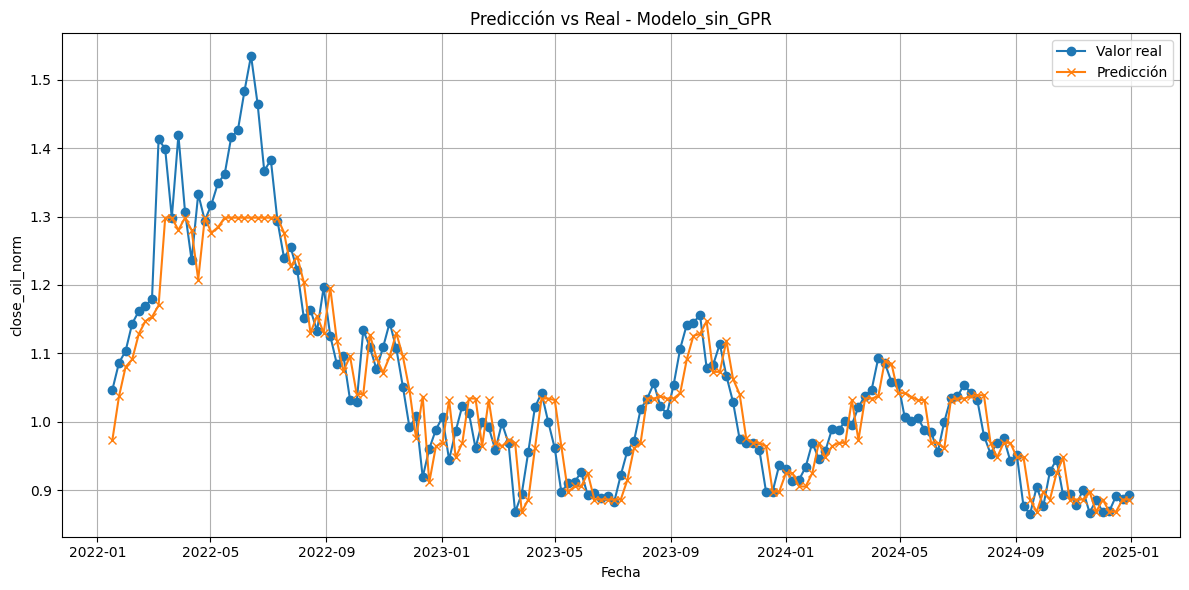

Entrenando Modelo_sin_GEPU con fuentes: ['GPR', 'ZEW', 'Conflicts', 'Elections', 'Sanctions', 'Oil', 'Time']


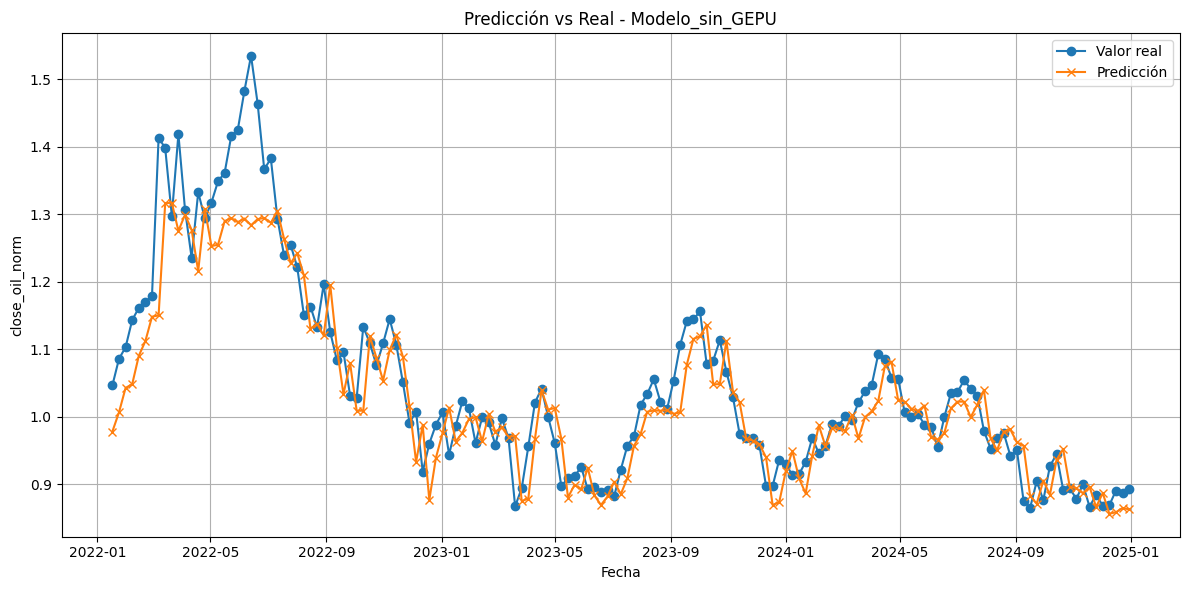

Entrenando Modelo_sin_ZEW con fuentes: ['GPR', 'GEPU', 'Conflicts', 'Elections', 'Sanctions', 'Oil', 'Time']


/tmp/ipython-input-4-2861339396.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_roll_4"] = df[col].shift(1).rolling(window=4).mean()


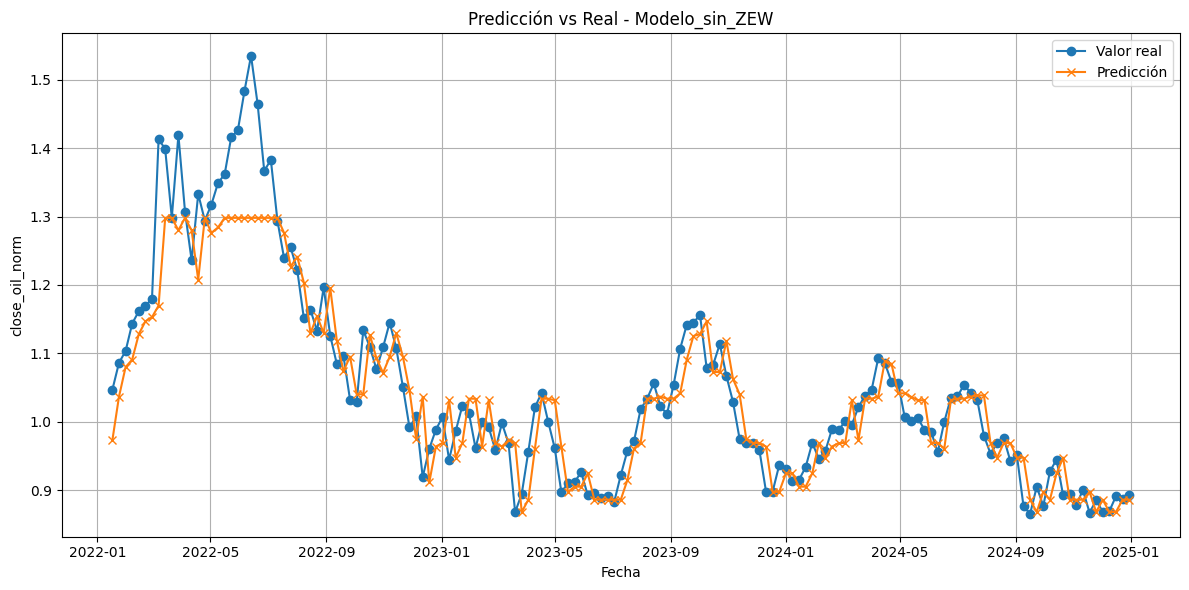

Entrenando Modelo_sin_Conflicts con fuentes: ['GPR', 'GEPU', 'ZEW', 'Elections', 'Sanctions', 'Oil', 'Time']


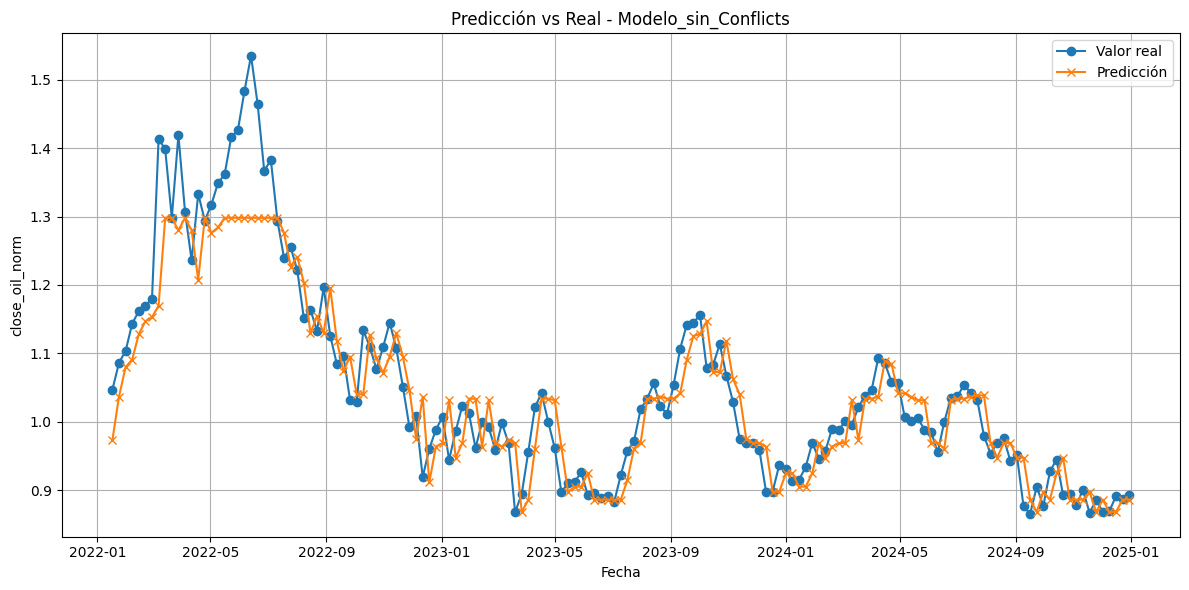

Entrenando Modelo_sin_Elections con fuentes: ['GPR', 'GEPU', 'ZEW', 'Conflicts', 'Sanctions', 'Oil', 'Time']


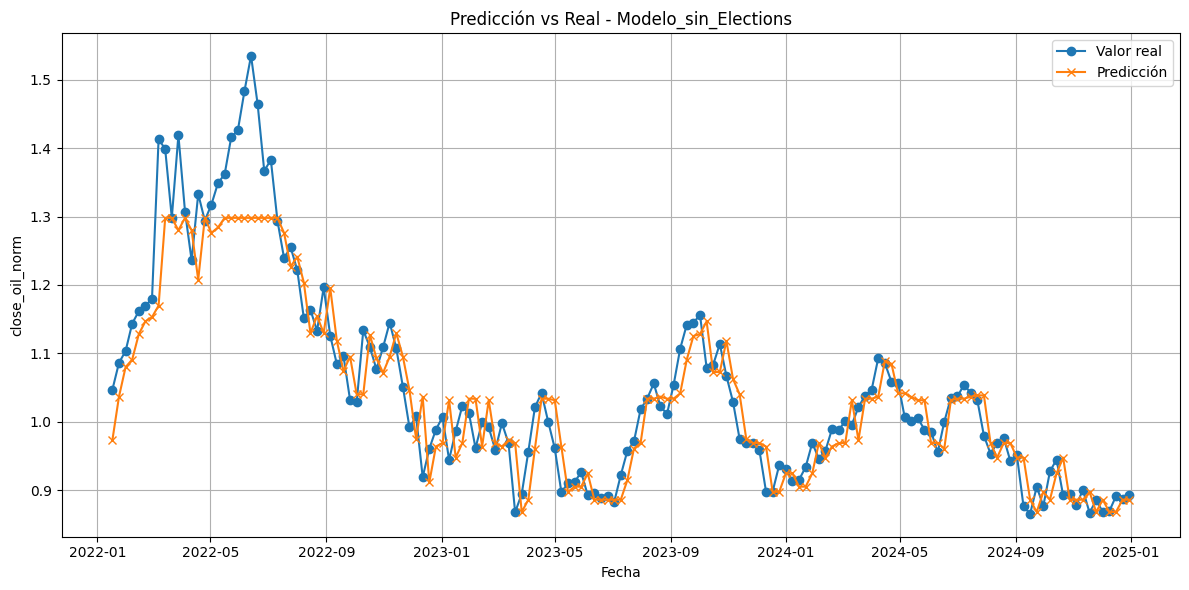

Entrenando Modelo_sin_Sanctions con fuentes: ['GPR', 'GEPU', 'ZEW', 'Conflicts', 'Elections', 'Oil', 'Time']


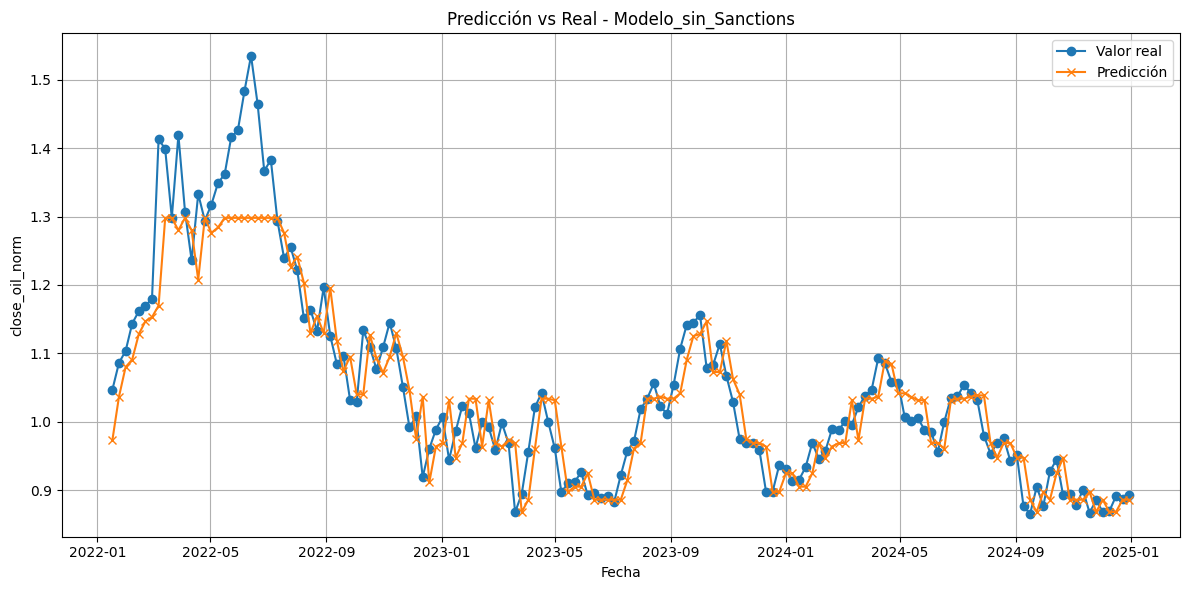

                 Modelo       MAE      RMSE        R2      MAPE
0         Modelo_Global  0.039091  0.055710  0.862499  3.549573
1        Modelo_sin_GPR  0.039030  0.055651  0.862790  3.544340
2       Modelo_sin_GEPU  0.042493  0.059436  0.843490  3.848282
3        Modelo_sin_ZEW  0.039091  0.055710  0.862499  3.549573
4  Modelo_sin_Conflicts  0.039091  0.055710  0.862499  3.549573
5  Modelo_sin_Elections  0.039091  0.055710  0.862499  3.549573
6  Modelo_sin_Sanctions  0.039091  0.055710  0.862499  3.549573


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Función de MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ------------------------------------------
# Preparar DataFrame (index temporal y cols a eliminar)
# ------------------------------------------
df["week"] = pd.to_datetime(df["week"])
df = df.set_index("week")

columnas_a_eliminar = [
    'OPEP_conflict_count', 'conflict_count', 'Iran_conflict_count', 'USA_involved',
    'shock_event', 'Iran_involved', 'OPEP_involved'
]
df = df.drop(columns=columnas_a_eliminar)

df["year"] = df.index.year
df["month"] = df.index.month

# ------------------------------------------
# Diccionario de fuentes (según tu clasificación)
# ------------------------------------------
fuentes = {
    "GPR": [col for col in df.columns if col.startswith("GPRC_")],
    "GEPU": [col for col in df.columns if col.startswith("GEPU_")] + ["GEPU_current"] if "GEPU_current" in df.columns else [],
    "ZEW": [col for col in df.columns if "zew" in col.lower()],
    "Conflicts": [
        "conflict_count_mask", "OPEP_involved_mask", "OPEP_conflict_count_mask",
        "USA_involved_mask", "Iran_involved_mask", "Iran_conflict_count_mask", "shock_event_mask"
    ],
    "Elections": [
        "num_elections", "elections_next_6_weeks", "num_compulsory_voting", "avg_voter_turnout"
    ],
    "Sanctions": [
        "OPEP_sanction_active", "num_sanctions"
    ],
    "Gold": ["Volume_gold", "kurtosis_gold"],
    "Oil": ["Volume_oil", "kurtosis_oil"],
    "Gas": ["Volume_gas", "kurtosis_gas"],
    "Time": ["year", "month"]
}

# ------------------------------------------
# Función para generar lags y rolling features
# ------------------------------------------
def crear_features_temporales(df, target_col, exog_cols):
    df = df.copy()

    # Lags y rolling del target
    df[f"{target_col}_lag_1"] = df[target_col].shift(1)
    df[f"{target_col}_lag_4"] = df[target_col].shift(4)
    df[f"{target_col}_roll_4"] = df[target_col].shift(1).rolling(window=4).mean()
    df[f"{target_col}_roll_12"] = df[target_col].shift(1).rolling(window=12).mean()

    # Lags y rolling de variables exógenas
    for col in exog_cols:
        df[f"{col}_lag_1"] = df[col].shift(1)
        df[f"{col}_roll_4"] = df[col].shift(1).rolling(window=4).mean()

    # Eliminar filas con NaNs generados
    df = df.dropna()

    return df

# ------------------------------------------
# Función que entrena y evalúa un modelo dado un listado de grupos de fuentes
# ------------------------------------------
def entrenar_y_evaluar(fuentes_sel, nombre_modelo):
    # Variables seleccionadas: juntar columnas de los grupos elegidos
    cols_seleccionadas = []
    for fuente in fuentes_sel:
        cols_seleccionadas += fuentes.get(fuente, [])

    # Eliminar duplicados
    cols_seleccionadas = list(set(cols_seleccionadas))

    # Nos quedamos sólo con las columnas que existan en df
    cols_seleccionadas = [c for c in cols_seleccionadas if c in df.columns]

    # Crear features temporales con el target y las variables exógenas seleccionadas
    df_feat = crear_features_temporales(df, "close_oil_norm", cols_seleccionadas)

    # Definir features (lags y rolling) y target
    # Las features serán todas las columnas menos el target original
    # Excluir también columnas originales no usadas
    target = "close_oil_norm"

    # Construimos la lista de features:
    # todos los cols seleccionados con sufijos _lag_1 y _roll_4 + los lags/rollings del target
    feature_cols = []
    # del target:
    feature_cols += [f"{target}_lag_1", f"{target}_lag_4", f"{target}_roll_4", f"{target}_roll_12"]
    # de exógenas:
    for col in cols_seleccionadas:
        feature_cols.append(f"{col}_lag_1")
        feature_cols.append(f"{col}_roll_4")
    # Añadir año y mes
    feature_cols += ["year", "month"]

    # Comprobar que todas las columnas existen en df_feat (puede que alguna no por falta de datos)
    feature_cols = [c for c in feature_cols if c in df_feat.columns]

    X = df_feat[feature_cols]
    y = df_feat[target]

    # División temporal 80%-20%
    split_index = int(len(df_feat) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Normalización del target
    mean_y_train = y_train.mean()
    std_y_train = y_train.std()
    y_train_norm = (y_train - mean_y_train) / std_y_train
    y_test_norm = (y_test - mean_y_train) / std_y_train

    # Modelo base
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )

    # Validación temporal
    tscv = TimeSeriesSplit(n_splits=3)

    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.03, 0.05, 0.1],
        'subsample': [0.6, 0.8],
        'gamma': [0, 1]
    }

    grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=tscv,
        verbose=0,
        n_jobs=-1
    )

    # Entrenar
    grid.fit(X_train, y_train_norm)

    best_model = grid.best_estimator_
    y_pred_norm = best_model.predict(X_test)
    y_pred_real = y_pred_norm * std_y_train + mean_y_train

    # Métricas
    mae = mean_absolute_error(y_test, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_real))
    r2 = r2_score(y_test, y_pred_real)
    mape_val = mape(y_test, y_pred_real)

    # Gráfico predicción vs real
    plt.figure(figsize=(12,6))
    plt.plot(y_test.index, y_test, label='Valor real', marker='o')
    plt.plot(y_test.index, y_pred_real, label='Predicción', marker='x')
    plt.title(f'Predicción vs Real - {nombre_modelo}')
    plt.xlabel('Fecha')
    plt.ylabel('close_oil_norm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Devolver métricas en dict
    return {
    "Modelo": nombre_modelo,
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape_val,
    "modelo_entrenado": best_model,
    "columnas_features": feature_cols
}

# ------------------------------------------
# Lista de modelos a probar (grupos de fuentes)
# ------------------------------------------
modelos_a_probar = [
    (["GPR", "GEPU", "ZEW", "Conflicts", "Elections", "Sanctions", "Oil", "Time"], "Modelo_Global"),
    (["GEPU", "ZEW", "Conflicts", "Elections", "Sanctions", "Oil", "Time"], "Modelo_sin_GPR"),
    (["GPR", "ZEW", "Conflicts", "Elections", "Sanctions", "Oil", "Time"], "Modelo_sin_GEPU"),
    (["GPR", "GEPU", "Conflicts", "Elections", "Sanctions", "Oil", "Time"], "Modelo_sin_ZEW"),
    (["GPR", "GEPU", "ZEW", "Elections", "Sanctions", "Oil", "Time"], "Modelo_sin_Conflicts"),
    (["GPR", "GEPU", "ZEW", "Conflicts", "Sanctions", "Oil", "Time"], "Modelo_sin_Elections"),
    (["GPR", "GEPU", "ZEW", "Conflicts", "Elections", "Oil", "Time"], "Modelo_sin_Sanctions"),
]

# DataFrame para guardar métricas
metrics_df = pd.DataFrame(columns=["Modelo", "MAE", "RMSE", "R2", "MAPE"])
modelos_guardados = {}


# ------------------------------------------
# Ejecutar y almacenar resultados
# ------------------------------------------
for fuentes_sel, nombre in modelos_a_probar:
    print(f"Entrenando {nombre} con fuentes: {fuentes_sel}")
    resultado = entrenar_y_evaluar(fuentes_sel, nombre)

    # Guarda métricas
    resultado_metr = {k: resultado[k] for k in ["Modelo", "MAE", "RMSE", "R2", "MAPE"]}
    metrics_df = pd.concat([metrics_df, pd.DataFrame([resultado_metr])], ignore_index=True)

    # Guarda modelo y features
    modelos_guardados[nombre] = {
        "modelo": resultado["modelo_entrenado"],
        "features": resultado["columnas_features"]
    }

# Mostrar resumen final
print(metrics_df)


In [8]:
# Análisis de importancia de variables
importances_df = pd.DataFrame()

for nombre_modelo, data in modelos_guardados.items():
    model = data["modelo"]
    features = data["features"]
    importancias = model.feature_importances_

    df_importancia = pd.DataFrame({
        "Variable": features,
        "Importancia": importancias,
        "Modelo": nombre_modelo
    })
    importances_df = pd.concat([importances_df, df_importancia], ignore_index=True)

# Ordenar para mostrar las más importantes por modelo
importances_df = importances_df.sort_values(by=["Modelo", "Importancia"], ascending=[True, False])


# mostrar
print(importances_df)

#export to csv
importances_df.to_csv("importances_oil_df.csv", index=False)


                          Variable  Importancia          Modelo
3           close_oil_norm_roll_12     0.573984   Modelo_Global
0             close_oil_norm_lag_1     0.249888   Modelo_Global
2            close_oil_norm_roll_4     0.081502   Modelo_Global
80            GEPU_Australia_lag_1     0.022666   Modelo_Global
11              GEPU_Mexico_roll_4     0.020733   Modelo_Global
..                             ...          ...             ...
341             GEPU_Canada_roll_4     0.000000  Modelo_sin_ZEW
342   elections_next_6_weeks_lag_1     0.000000  Modelo_sin_ZEW
343  elections_next_6_weeks_roll_4     0.000000  Modelo_sin_ZEW
344                           year     0.000000  Modelo_sin_ZEW
345                          month     0.000000  Modelo_sin_ZEW

[626 rows x 3 columns]


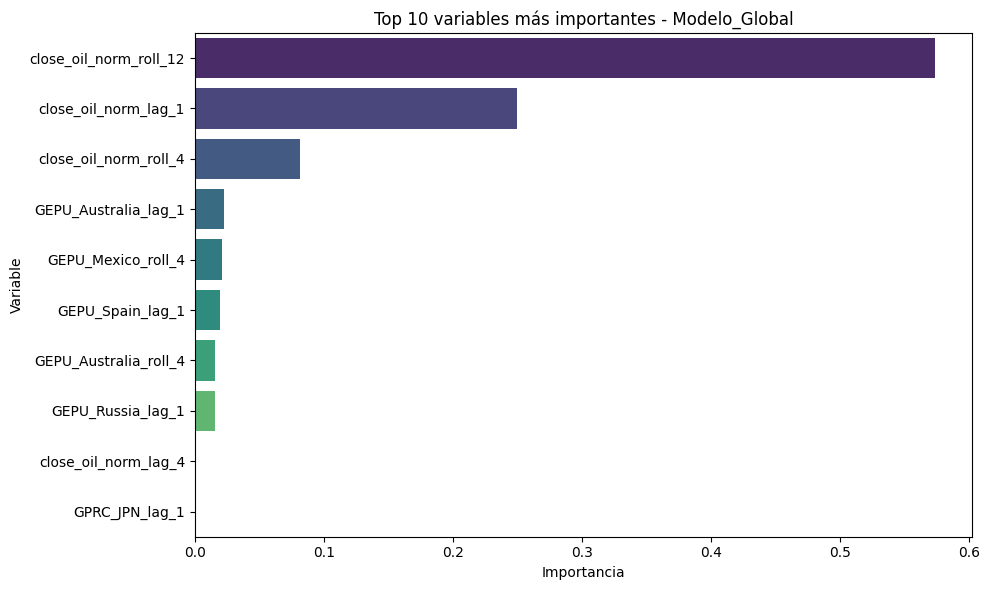

/tmp/ipython-input-6-424858219.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vars, x="Importancia", y="Variable", palette="viridis")


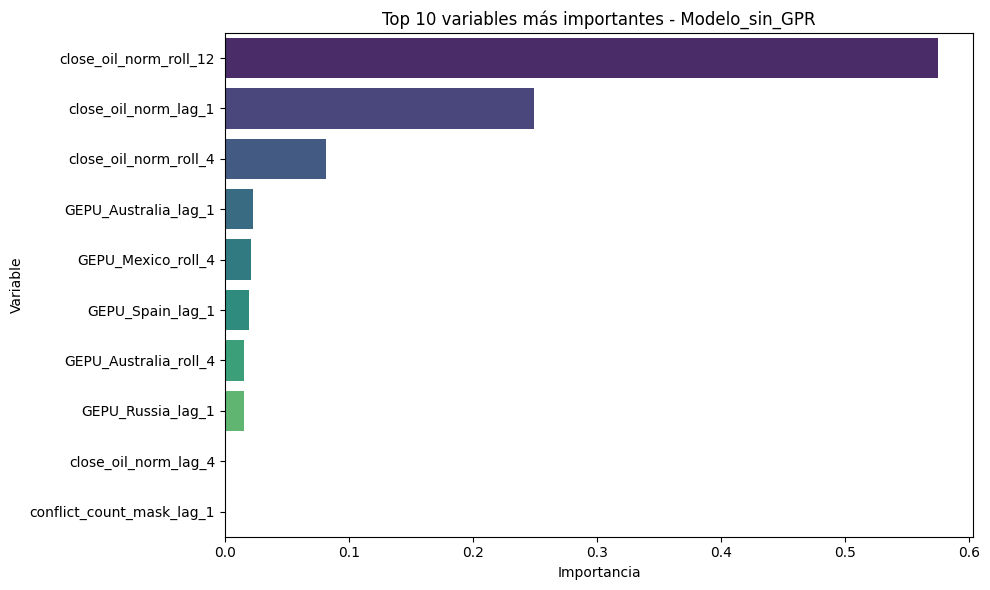

/tmp/ipython-input-6-424858219.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vars, x="Importancia", y="Variable", palette="viridis")


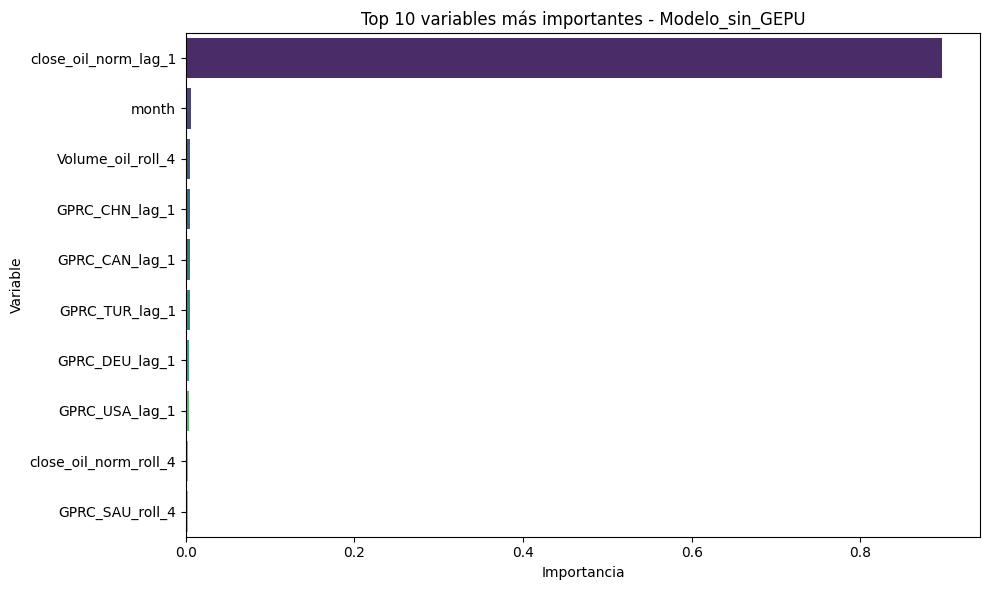

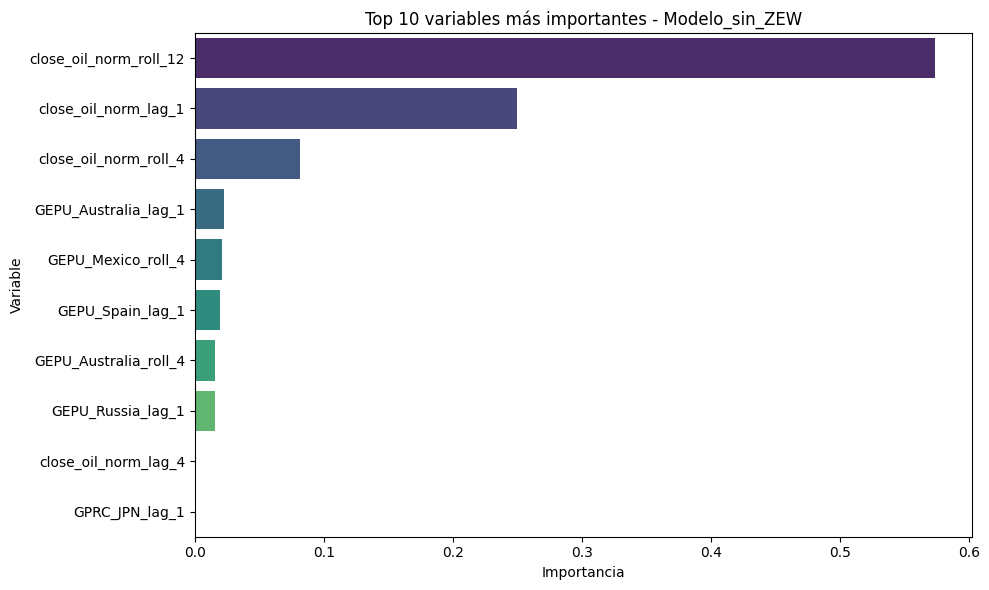

/tmp/ipython-input-6-424858219.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vars, x="Importancia", y="Variable", palette="viridis")


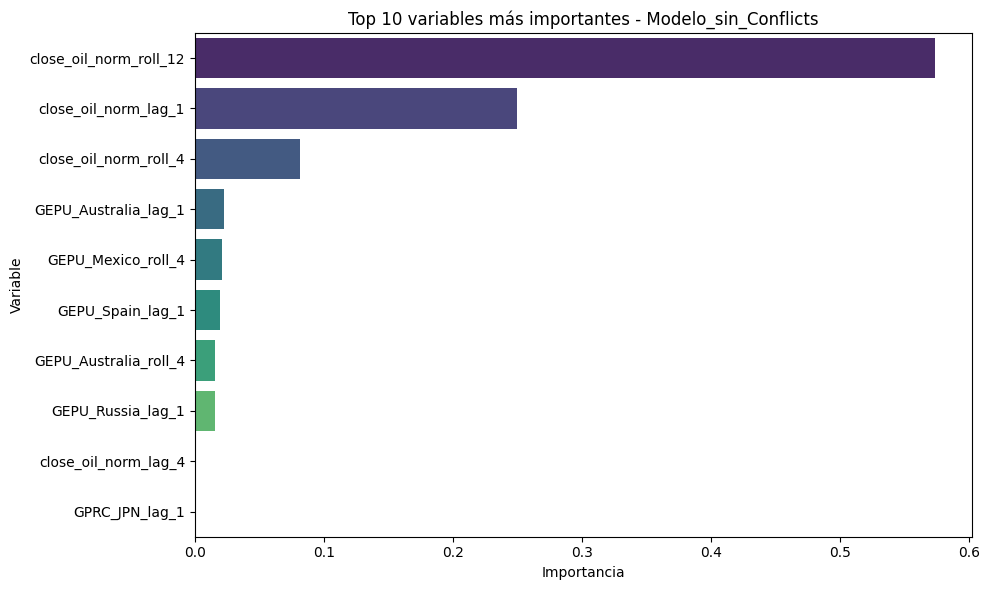

/tmp/ipython-input-6-424858219.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vars, x="Importancia", y="Variable", palette="viridis")


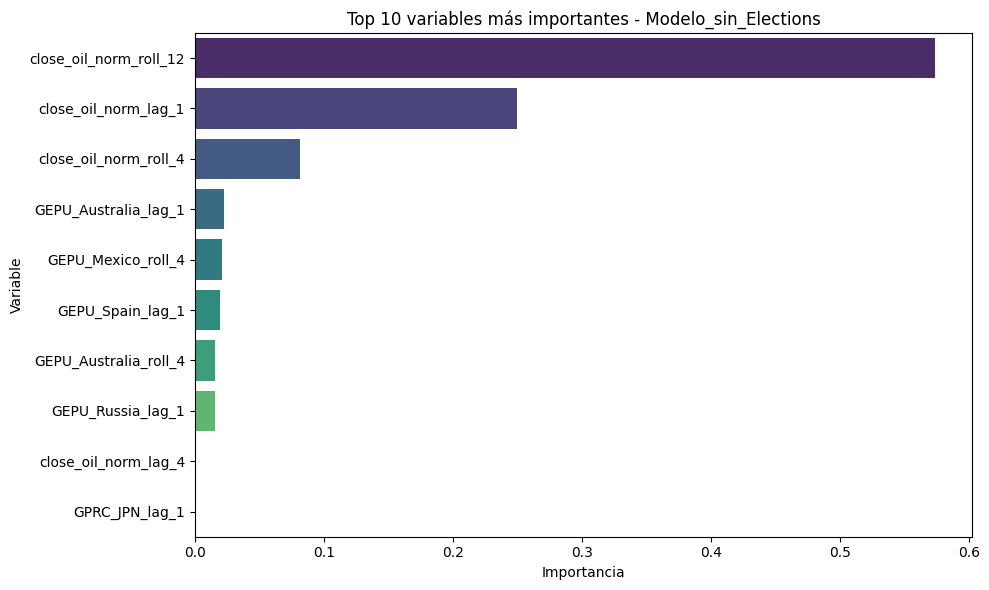

/tmp/ipython-input-6-424858219.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vars, x="Importancia", y="Variable", palette="viridis")


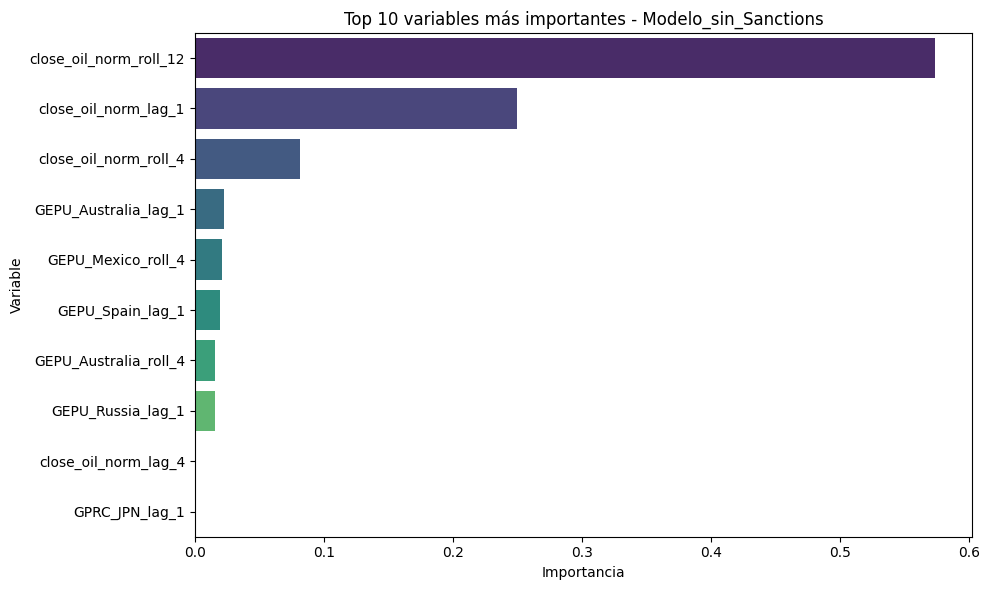

In [6]:
import seaborn as sns

top_n = 10  # Número de variables más importantes a mostrar

for nombre_modelo, info_modelo in modelos_guardados.items():
    modelo = info_modelo["modelo"]
    features = info_modelo["features"]

    # Obtener importancias y emparejarlas con los nombres de features
    importancias = modelo.feature_importances_
    importances_df = pd.DataFrame({
        "Variable": features,
        "Importancia": importancias
    })

    # Obtener top N
    top_vars = importances_df.nlargest(top_n, "Importancia")

    # Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_vars, x="Importancia", y="Variable", palette="viridis")
    plt.title(f"Top {top_n} variables más importantes - {nombre_modelo}")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()
